# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, udf, isnan, count, when, desc, sort_array, asc, avg, lag, floor
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType, DateType
from pyspark.sql.functions import sum as Fsum
import datetime

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("spark_capstone").getOrCreate()

# Load and Clean Dataset
Clean your dataset, checking for invalid or missing data. For example, records without userids or sessionids. In this workspace, the filename is `mini_sparkify_event_data.json`.

In [3]:
data = spark.read.json("mini_sparkify_event_data.json")

In [4]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
print(data.select("userId").where(data.userId =="").count(), 
      data.select("sessionId").where(data.sessionId =="").count())

8346 0


In [6]:
print(data.count(), data.dropna(how='any').count(), data.dropna(how='any', subset=['userId', 'sessionId']).count())
#no NA values in these two columns. the rest of the columns could have 'null' values but depending on what user is
#doing we do not always need to have every field filled

286500 228108 286500


In [7]:
df = data.where((data.userId != "") | (data.sessionId != ""))

In [8]:
df.count()

278154

In [9]:
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [10]:
df.collect()[0]

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [11]:
for column in df.columns:
    print(f'{column.title()} unique values: {df.select(column).dropDuplicates().count()}')
    df.select(column).dropDuplicates().sort(column).show(5)


Artist unique values: 17656
+--------------------+
|              artist|
+--------------------+
|                null|
|                 !!!|
|        & And Oceans|
|'N Sync/Phil Collins|
|        'Til Tuesday|
+--------------------+
only showing top 5 rows

Auth unique values: 2
+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+

Firstname unique values: 189
+---------+
|firstName|
+---------+
| Adelaida|
|   Adrian|
|  Adriana|
|   Adriel|
|  Ainsley|
+---------+
only showing top 5 rows

Gender unique values: 2
+------+
|gender|
+------+
|     F|
|     M|
+------+

Iteminsession unique values: 1311
+-------------+
|itemInSession|
+-------------+
|            0|
|            1|
|            2|
|            3|
|            4|
+-------------+
only showing top 5 rows

Lastname unique values: 173
+---------+
| lastName|
+---------+
|    Adams|
|  Aguilar|
|Alexander|
|    Allen|
| Atkinson|
+---------+
only showing top 5 rows

Length unique values: 14866
+-------+
| 

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [67]:
churn = udf(lambda x: int(x=="Cancellation Confirmation"), IntegerType())
downgrade_churn = udf(lambda x: int(x=="Submit Downgrade"), IntegerType())

df = df.withColumn("downgraded", downgrade_churn("page")).withColumn("cancelled", churn("page"))

In [68]:
#distribution of users downgrades and cancellations
df.select(['userId', 'downgraded', 'cancelled'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(downgraded)', 'downgraded')\
    .withColumnRenamed('sum(cancelled)', 'cancelled').describe().show()

+-------+------------------+------------------+------------------+
|summary|            userId|        downgraded|         cancelled|
+-------+------------------+------------------+------------------+
|  count|               225|               225|               225|
|   mean|65391.013333333336|              0.28|0.2311111111111111|
| stddev|105396.47791907164|0.5876709477736184|0.4224832108996327|
|    min|                10|                 0|                 0|
|    max|                99|                 3|                 1|
+-------+------------------+------------------+------------------+



In [69]:
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

In [70]:
df = df.withColumn("churn_phase", Fsum("cancelled").over(windowval))\
    .withColumn("downgrade_phase", Fsum("downgraded").over(windowval))

In [71]:
song=udf(lambda x : int(x=='NextSong'), IntegerType())
home_visit=udf(lambda x : int(x=='Home'), IntegerType())
df = df.withColumn('date', get_day(col('ts')))

In [72]:
#difference in number of songs played between users who churned and didnt?
df.filter(col('churn_phase')==1).withColumn('songPlayed', song(col('page'))).agg({'songPlayed':'mean'}).show()
df.filter(col('churn_phase')==0).withColumn('songPlayed', song(col('page'))).agg({'songPlayed':'mean'}).show()

+------------------+
|   avg(songPlayed)|
+------------------+
|0.8112072039942939|
+------------------+

+------------------+
|   avg(songPlayed)|
+------------------+
|0.8217840456084702|
+------------------+



In [32]:
#number of songs played between home visits
cusum = df.filter((df.page == 'NextSong') | (df.page == 'Home')) \
    .select('userID', 'page', 'ts', 'churn_phase') \
    .withColumn('homevisit', home_visit(col('page'))) \
    .withColumn('songPeriod', Fsum('homevisit').over(windowval))

cusum.filter((cusum.churn_phase == 1) &(cusum.page == 'NextSong')) \
    .groupBy('userID', 'songPeriod') \
    .agg({'songPeriod':'count'}) \
    .agg({'count(songPeriod)':'avg'}).show()

cusum.filter((cusum.churn_phase == 0) &(cusum.page == 'NextSong')) \
    .groupBy('userID', 'songPeriod') \
    .agg({'songPeriod':'count'}) \
    .agg({'count(songPeriod)':'avg'}).show()

+----------------------+
|avg(count(songPeriod))|
+----------------------+
|      22.6612702366127|
+----------------------+

+----------------------+
|avg(count(songPeriod))|
+----------------------+
|     23.79175974187143|
+----------------------+



In [61]:
days = lambda i: i * 86400 
daywindow = Window.partitionBy('userId', 'date').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())

In [74]:
#number of songs played daily
df.filter((df.page=='NextSong')&(col('churn_phase')==1)).select('userId', 'page', 'ts')\
    .withColumn('date', get_day(col('ts'))).groupBy('userId', 'date').count().describe().show()

df.filter((df.page=='NextSong')&(col('churn_phase')==0)).select('userId', 'page', 'ts')\
    .withColumn('date', get_day(col('ts'))).groupBy('userId', 'date').count().describe().show()

+-------+-----------------+-----------------+
|summary|           userId|            count|
+-------+-----------------+-----------------+
|  count|              499|              499|
|   mean|77394.81563126252|72.93386773547094|
| stddev|90869.89716037885|71.24764235703725|
|    min|           100001|                1|
|    max|               87|              346|
+-------+-----------------+-----------------+

+-------+------------------+-----------------+
|summary|            userId|            count|
+-------+------------------+-----------------+
|  count|              2559|             2559|
|   mean| 64501.19812426729|74.91754591637358|
| stddev|114144.74005493976|74.02407951472078|
|    min|                10|                1|
|    max|                99|              360|
+-------+------------------+-----------------+



In [38]:
df.filter((df.page=='NextSong')&(df.churn_phase==1)).select('userId', 'page', 'ts', 'length')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'length':'avg'}).describe().show()

df.filter((df.page=='NextSong')&(df.churn_phase==0)).select('userId', 'page', 'ts', 'length')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'length':'avg'}).describe().show()

+-------+-----------------+-----------------+
|summary|           userId|      avg(length)|
+-------+-----------------+-----------------+
|  count|              499|              499|
|   mean|77394.81563126252|248.0824544167563|
| stddev|90869.89716037885|23.07628700860933|
|    min|           100001|         45.63546|
|    max|               87|388.1704313333333|
+-------+-----------------+-----------------+

+-------+------------------+------------------+
|summary|            userId|       avg(length)|
+-------+------------------+------------------+
|  count|              2559|              2559|
|   mean| 64501.19812426729|249.48107841849443|
| stddev|114144.74005493976|27.895620078076377|
|    min|                10|         139.51955|
|    max|                99|         998.42567|
+-------+------------------+------------------+



In [39]:
df.filter((df.page=='Error')&(df.churn_phase==1)).select('userId', 'page', 'ts', 'length')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'page':'count'}).select('count(page)').describe().show()

df.filter((df.page=='Error')&(df.churn_phase==0)).select('userId', 'page', 'ts', 'length')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'page':'count'}).select('count(page)').describe().show()

+-------+------------------+------------------+
|summary|            userId|       count(page)|
+-------+------------------+------------------+
|  count|                30|                30|
|   mean| 90038.96666666666|1.0666666666666667|
| stddev|102864.62817988047|0.2537081317024624|
|    min|            100001|                 1|
|    max|                73|                 2|
+-------+------------------+------------------+

+-------+------------------+-------------------+
|summary|            userId|        count(page)|
+-------+------------------+-------------------+
|  count|               200|                200|
|   mean|         56066.625|                1.1|
| stddev|110994.57366660556|0.31702131247412063|
|    min|               100|                  1|
|    max|                98|                  3|
+-------+------------------+-------------------+



In [42]:
df.filter((df.page=='Help')&(df.churn_phase==1)).select('userId', 'page', 'ts', 'length')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'page':'count'}).describe().show()

df.filter((df.page=='Help')&(df.churn_phase==0)).select('userId', 'page', 'ts', 'length')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'page':'count'}).describe().show()

+-------+-----------------+------------------+
|summary|           userId|       count(page)|
+-------+-----------------+------------------+
|  count|              171|               171|
|   mean|62613.21052631579|1.3976608187134503|
| stddev| 88778.9002607509|0.8078987426633197|
|    min|           100001|                 1|
|    max|               87|                 6|
+-------+-----------------+------------------+

+-------+------------------+------------------+
|summary|            userId|       count(page)|
+-------+------------------+------------------+
|  count|               816|               816|
|   mean| 63176.38602941176|1.4889705882352942|
| stddev|115512.27837413888|0.8636495080491383|
|    min|                10|                 1|
|    max|                99|                 8|
+-------+------------------+------------------+



In [29]:
#ratio of those who cancelled free/paid
print(df.filter((df.page=='Cancellation Confirmation') & (df.level=='paid')).count(),
df.filter((df.page=='Cancellation Confirmation') & (df.level=='free')).count())

31 21


In [36]:
#number of users who downgraded
#number of users to cancel
print(df.filter(col('downgraded')==1).select('userId').dropDuplicates().count(), 
      df.filter(col('cancelled')==1).select('userId').dropDuplicates().count())

49 52


In [35]:
#users who both downgraded and cancelled
df.select(['userId', 'downgraded', 'cancelled'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(downgraded)', 'downgraded')\
    .withColumnRenamed('sum(cancelled)', 'cancelled')\
    .filter((col("downgraded")==1)&(col("cancelled")==1))\
    .count()

9

In [37]:
#number of users to cancel w/o downgrade
df.select(['userId', 'downgraded', 'cancelled'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(downgraded)', 'downgraded')\
    .withColumnRenamed('sum(cancelled)', 'cancelled')\
    .filter((col("downgraded")==0)&(col("cancelled")==1))\
    .count()

43

In [22]:
#number of paid users to drop without downgrading -> big chunk of those
print(df.filter((col('cancelled')==1) & (col('downgraded')==0) & (col('level')=='paid'))\
      .select('userId').dropDuplicates().count())

31


In [23]:
#do those who churn or dont have different listening habits?
df.filter(col('cancelled')==1).agg({'length':'mean'}).show()
df.filter(col('cancelled')==0).agg({'length':'mean'}).show()

+-----------------+
|      avg(length)|
+-----------------+
|248.6327956440622|
+-----------------+

+------------------+
|       avg(length)|
+------------------+
|249.20913538880808|
+------------------+



In [43]:
#difference in registration time between quitting? -> difference in mean is two days
df.filter(col('cancelled')==1).agg({'registration':'mean'}).show()
df.filter(col('cancelled')==0).agg({'registration':'mean'}).show()

+--------------------+
|   avg(registration)|
+--------------------+
|1.535690562980769...|
+--------------------+

+--------------------+
|   avg(registration)|
+--------------------+
|1.535358772057175E12|
+--------------------+



Check if distribution in when user signed up for service. Maybe older members need to be incentivised more
- there seems to be no difference

In [50]:
registration_num = df.select('userId','registration').dropDuplicates()

In [54]:
user_duration_check = df.select(['userId', 'downgraded', 'cancelled', 'registration'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(downgraded)', 'downgraded')\
    .withColumnRenamed('sum(cancelled)', 'cancelled')\
    .join(registration_num, on='userId')

In [56]:
user_duration_check\
    .filter(col('cancelled')==0).select('registration').describe().show()
user_duration_check\
    .filter(col('cancelled')==1).select('registration').describe().show()

+-------+--------------------+
|summary|        registration|
+-------+--------------------+
|  count|                 173|
|   mean|1.535574755809248...|
| stddev|2.9472764868760366E9|
|    min|       1521380675000|
|    max|       1543247354000|
+-------+--------------------+

+-------+--------------------+
|summary|        registration|
+-------+--------------------+
|  count|                  52|
|   mean|1.535690562980769...|
| stddev|2.6165689809729304E9|
|    min|       1526739206000|
|    max|       1538333829000|
+-------+--------------------+



In [41]:
#difference in rates of genders in cancelling - gray area ethically
df.filter(col('cancelled')==1).groupBy('gender').count().show()
df.filter(col('cancelled')==0).groupBy('gender').count().show()

+------+-----+
|gender|count|
+------+-----+
|     F|   20|
|     M|   32|
+------+-----+

+------+------+
|gender| count|
+------+------+
|     F|154558|
|     M|123544|
+------+------+



Other options for future analysis:
- how many users went to `downgrade` but did not `submit downgrade`
- how many users went to `cancel` but did not `submit cancel`
- rates of `add friend`

# Feature Engineering - Data Preprocessing
Overview:
- create user level data based on user actions (pages visited, songs listened to, etc).
- set up data for machine learning algorithms (ML algos use specific data types in Spark)

Steps:
1. create dataframe of user ids. This will be used to merge all the other features that will be created into one dataset
2. Clean data of any rows where user id or session id are null, as this would interfere with feature engineering
3. Create features
4. combine features into one dataframe using the join() method
5. The features must be converted using the VectorAssembler, so that each row has a Vector object (array like) that machine learning algorithms. This column will be called 'features'
6. Convert the column 'cancelled' into DoubleType and call the column 'labels'. This is default for PySpark.ML
7. Scale the input features 

In [114]:
#1. dataframe of user ids to merge onto
data = spark.read.json("mini_sparkify_event_data.json")
data.show(2)

+------+
|userId|
+------+
|100010|
|200002|
+------+
only showing top 2 rows



In [58]:
df = data
data = df.where((df.userId != "") | (df.sessionId != "")).select('userId').dropDuplicates() #extract user ids

df = df.where((df.userId != "") | (df.sessionId != ""))

In [48]:
churn = udf(lambda x: int(x=="Cancellation Confirmation"), IntegerType())
downgrade_churn = udf(lambda x: int(x=="Submit Downgrade"), IntegerType())
visited_downgrade = udf(lambda x: int(x=='Downgrade'), IntegerType())
visited_cancel = udf(lambda x: int(x=='Cancel'), IntegerType())

In [49]:
avgThumbsUp = df.filter(df.page=='Thumbs Up').select('userId', 'page', 'ts')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'page':'count'}).groupBy('userId')\
    .mean().withColumnRenamed('avg(count(page))', 'avgThumbsUp')

In [109]:
avgThumbsDown = df.filter(df.page=='Thumbs Down').select('userId', 'page', 'ts')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'page':'count'}).groupBy('userId')\
    .mean().withColumnRenamed('avg(count(page))', 'avgThumbsDown')

In [112]:
numFriends = df.filter(df.page=='Add Friend').select('userId', 'page')\
    .groupBy('userId').count().withColumnRenamed('count', 'numFriends')

In [81]:
session = Window.partitionBy("userId", "sessionId").orderBy(desc("ts"))

In [53]:
song = udf(lambda x: int(x=='NextSong'), IntegerType())
days = lambda i: i * 86400 
daywindow = Window.partitionBy('userId', 'date').orderBy(desc('ts')).rangeBetween(Window.unboundedPreceding, 0)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())

In [54]:
skipped = udf(lambda x: int(x!=0), IntegerType())

In [94]:
'''
process

1. dont include thumbs up and down pages because that usually occurs while playing and does not change song
2. create variable for if action is song
3. check if next action is song - this will check to see if someone is skipping song or just leaving page
4. get the difference in timestamp for next action song playing
5. subtract the difference in timestamp from song length to see how much of song was skipped
6. get descriptive stats
'''

skipping = df.select('userId', 'page', 'ts', 'length', 'sessionId', 'itemInSession')\
    .where((df.page != 'Thumbs Up') & (df.page != 'Thumbs Down'))\
    .withColumn('song', song('page')).orderBy('userId', 'sessionId', 'itemInSession')\
    .withColumn('nextActSong', lag(col('song')).over(session))\
    .withColumn('tsDiff', (lag('ts').over(session)-col('ts'))/1000)\
    .withColumn('timeSkipped', (floor('length')-col('tsDiff')))\
    .withColumn('roundedLength', floor('length'))\
    .where((col('song')==1) & ((col('nextActSong')!=0)&(col('timeSkipped')>=0)))\
    .withColumn('skipped', skipped('timeSkipped'))\
    .select('userId', 'timeSkipped', 'skipped', 'length', 'ts', 'tsDiff')\
    .groupBy('userId').agg({'skipped':'avg', 'timeSkipped':'avg'})\
    .withColumnRenamed('avg(skipped)', 'skipRate')\
    .withColumnRenamed('avg(timeSkipped)', 'avgTimeSkipped')

In [95]:
#avg daily visits to help site
dailyHelpVisit = df.filter(df.page=='Help').select('userId', 'page', 'ts', 'length')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'page':'count'}).groupBy('userId').mean()\
                     .withColumnRenamed('avg(count(page))', 'dailyHelpVisits')

dailyErrors = df.filter(df.page=='Error').select('userId', 'page', 'ts', 'length')\
    .withColumn('date', get_day(col('ts')))\
    .groupBy('userId', 'date').agg({'page':'count'}).groupBy('userId').mean()\
                     .withColumnRenamed('avg(count(page))', 'dailyErrors')

In [96]:
#whether a user has downgraded
churn = df.withColumn("downgraded", downgrade_churn("page"))\
    .withColumn("cancelled", churn("page"))\
    .withColumn('visited_cancel', visited_cancel('page'))\
    .withColumn('visited_downgrade', visited_downgrade('page'))\
    .select(['userId', 'downgraded', 'cancelled', 'visited_cancel', 'visited_downgrade'])\
    .groupBy('userId').sum()\
    .withColumnRenamed('sum(downgraded)', 'downgraded')\
    .withColumnRenamed('sum(cancelled)', 'cancelled')\
    .withColumnRenamed('sum(visited_cancel)', 'visited_cancel')\
    .withColumnRenamed('sum(visited_downgrade)', 'visited_downgrade')

In [97]:
free = udf(lambda x: int(x=='free'), IntegerType())
paid = udf(lambda x: int(x=='paid'), IntegerType())

user_level = df.select('userId', 'level').where((df.level=='free')|(df.level=='paid'))\
    .dropDuplicates()\
    .withColumn('free', free('level'))\
    .withColumn('paid', paid('level')).drop('level')

In [100]:
home_visit=udf(lambda x : int(x=='Home'), IntegerType())
windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

cusum = df.filter((df.page == 'NextSong') | (df.page == 'Home')) \
    .select('userID', 'page', 'ts') \
    .withColumn('homevisit', home_visit(col('page'))) \
    .withColumn('songPeriod', Fsum('homevisit').over(windowval))\

In [101]:
avgSongsTillHome = cusum.filter((cusum.page=='NextSong'))\
    .groupBy('userId', 'songPeriod')\
    .agg({'songPeriod':'count'}).drop('songPeriod').groupby('userId').mean()\
    .withColumnRenamed('avg(count(songPeriod))', 'avgSongsTillHome')

In [115]:
data = data.join(churn, on='userId')\
    .join(dailyHelpVisit, on='userId')\
    .join(dailyErrors, on='userId')\
    .join(user_level, on='userId')\
    .join(avgThumbsUp, on='userId')\
    .join(avgThumbsDown, on='userId')\
    .join(numFriends, on='userId')\
    .join(avgSongsTillHome, on='userId')\
    .join(skipping, on='userId')

In [116]:
data.printSchema()

root
 |-- userId: string (nullable = true)
 |-- downgraded: long (nullable = true)
 |-- cancelled: long (nullable = true)
 |-- visited_cancel: long (nullable = true)
 |-- visited_downgrade: long (nullable = true)
 |-- dailyHelpVisits: double (nullable = true)
 |-- dailyErrors: double (nullable = true)
 |-- free: integer (nullable = true)
 |-- paid: integer (nullable = true)
 |-- avgThumbsUp: double (nullable = true)
 |-- avgThumbsDOwn: double (nullable = true)
 |-- numFriends: long (nullable = false)
 |-- avgSongsTillHome: double (nullable = true)
 |-- avgTimeSkipped: double (nullable = true)
 |-- skipRate: double (nullable = true)



Below are functions that combine all feature engineering steps, as well as feature scaling and data type casting.

In [4]:
def feature_engineering(filepath):
    '''
    Create necessary features to use machine learning algorithms.
    First loads data set from file
    
    Resulting DF Strucutre:
    
    root
     |-- userId: string
     |-- downgraded: long
     |-- cancelled: long
     |-- visited_cancel: long
     |-- visited_downgrade: long
     |-- dailyHelpVisits: double
     |-- dailyErrors: double
     |-- free: integer
     |-- paid: integer
     |-- avgThumbsUp: double
     |-- avgThumbsDOwn: double
     |-- numFriends: long
     |-- avgSongsTillHome: double
     |-- avgTimeSkipped: double
     |-- skipRate: double
    
    Inputs
        filepath (str) - path to json dataset on file
        
    Outputs
        data - engineered dataset
    '''
    #dataframe of user ids to merge onto
    df = spark.read.json(filepath)
    users = df.where((df.userId != "") | (df.sessionId != ""))\
        .select('userId').dropDuplicates()
    
    #define custom functions
    churn = udf(lambda x: int(x=="Cancellation Confirmation"), IntegerType())
    downgrade_churn = udf(lambda x: int(x=="Submit Downgrade"), IntegerType())
    visited_downgrade = udf(lambda x: int(x=='Downgrade'), IntegerType())
    visited_cancel = udf(lambda x: int(x=='Cancel'), IntegerType())
    song = udf(lambda x: int(x=='NextSong'), IntegerType())
    days = lambda i: i * 86400 
    get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())
    skipped = udf(lambda x: int(x!=0), IntegerType())
    free = udf(lambda x: int(x=='free'), IntegerType())
    paid = udf(lambda x: int(x=='paid'), IntegerType())
    home_visit=udf(lambda x : int(x=='Home'), IntegerType())
    
    #define windows
    windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
    session = Window.partitionBy("userId", "sessionId").orderBy(desc("ts"))
    daywindow = Window.partitionBy('userId', 'date').orderBy(desc('ts'))\
        .rangeBetween(Window.unboundedPreceding, 0)

    avgThumbsUp = df.filter(df.page=='Thumbs Up')\
        .select('userId', 'page', 'ts')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'}).groupBy('userId')\
        .mean().withColumnRenamed('avg(count(page))', 'avgThumbsUp')
    
    avgThumbsDown = df.filter(df.page=='Thumbs Down')\
        .select('userId', 'page', 'ts')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .groupBy('userId').mean()\
        .withColumnRenamed('avg(count(page))', 'avgThumbsDown')
    
    numFriends = df.filter(df.page=='Add Friend')\
        .select('userId', 'page')\
        .groupBy('userId').count().withColumnRenamed('count', 'numFriends')
    
    '''
    process for calculating skipping variables

    1. dont include thumbs up and down pages because that usually occurs 
        while playing and does not change song
    2. create variable for if action is song
    3. check if next action is song - this will check to see if someone is 
        skipping song or just leaving page
    4. get the difference in timestamp for next action song playing
    5. subtract the difference in timestamp from song length to see 
        how much of song was skipped
    6. get descriptive stats
    '''

    skipping = df.select('userId', 'page', 'ts', 'length', 'sessionId', 'itemInSession')\
        .where((df.page != 'Thumbs Up') & (df.page != 'Thumbs Down'))\
        .withColumn('song', song('page')).orderBy('userId', 'sessionId', 'itemInSession')\
        .withColumn('nextActSong', lag(col('song')).over(session))\
        .withColumn('tsDiff', (lag('ts').over(session)-col('ts'))/1000)\
        .withColumn('timeSkipped', (floor('length')-col('tsDiff')))\
        .withColumn('roundedLength', floor('length'))\
        .where((col('song')==1) & ((col('nextActSong')!=0)&(col('timeSkipped')>=0)))\
        .withColumn('skipped', skipped('timeSkipped'))\
        .select('userId', 'timeSkipped', 'skipped', 'length', 'ts', 'tsDiff')\
        .groupBy('userId').agg({'skipped':'avg', 'timeSkipped':'avg'})\
        .withColumnRenamed('avg(skipped)', 'skipRate')\
        .withColumnRenamed('avg(timeSkipped)', 'avgTimeSkipped')
    
#avg daily visits to help site
    dailyHelpVisit = df.filter(df.page=='Help')\
        .select('userId', 'page', 'ts', 'length')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .groupBy('userId').mean()\
         .withColumnRenamed('avg(count(page))', 'dailyHelpVisits')

    dailyErrors = df.filter(df.page=='Error')\
        .select('userId', 'page', 'ts', 'length')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .groupBy('userId').mean()\
        .withColumnRenamed('avg(count(page))', 'dailyErrors')
    
    #whether a user has downgraded
    churn = df.withColumn("downgraded", downgrade_churn("page"))\
        .withColumn("cancelled", churn("page"))\
        .withColumn('visited_cancel', visited_cancel('page'))\
        .withColumn('visited_downgrade', visited_downgrade('page'))\
        .select(['userId', 'downgraded', 'cancelled', 'visited_cancel', 'visited_downgrade'])\
        .groupBy('userId').sum()\
        .withColumnRenamed('sum(downgraded)', 'downgraded')\
        .withColumnRenamed('sum(cancelled)', 'cancelled')\
        .withColumnRenamed('sum(visited_cancel)', 'visited_cancel')\
        .withColumnRenamed('sum(visited_downgrade)', 'visited_downgrade')

    user_level = df.select('userId', 'level')\
        .where((df.level=='free')|(df.level=='paid'))\
        .dropDuplicates()\
        .withColumn('free', free('level'))\
        .withColumn('paid', paid('level')).drop('level')

    cusum = df.filter((df.page == 'NextSong') | (df.page == 'Home')) \
        .select('userID', 'page', 'ts') \
        .withColumn('homevisit', home_visit(col('page'))) \
        .withColumn('songPeriod', Fsum('homevisit').over(windowval))\
    
    avgSongsTillHome = cusum.filter((cusum.page=='NextSong'))\
        .groupBy('userId', 'songPeriod')\
        .agg({'songPeriod':'count'}).drop('songPeriod')\
        .groupby('userId').mean()\
        .withColumnRenamed('avg(count(songPeriod))', 'avgSongsTillHome')
    
    df = users.join(churn, on='userId')\
        .join(dailyHelpVisit, on='userId')\
        .join(dailyErrors, on='userId')\
        .join(user_level, on='userId')\
        .join(avgThumbsUp, on='userId')\
        .join(avgThumbsDown, on='userId')\
        .join(numFriends, on='userId')\
        .join(avgSongsTillHome, on='userId')\
        .join(skipping, on='userId')
    
    return df

In [8]:
data_small.drop('userId').columns

['downgraded',
 'cancelled',
 'visited_cancel',
 'visited_downgrade',
 'dailyHelpVisits',
 'dailyErrors',
 'free',
 'paid',
 'avgThumbsUp',
 'avgThumbsDown',
 'numFriends',
 'avgSongsTillHome',
 'avgTimeSkipped',
 'skipRate']

In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler #used because won't distort binary vars
from pyspark.sql.types import DoubleType

def feature_scaling(df):
    feature_cols = df.drop('userId', 'cancelled').columns
    assembler = VectorAssembler(inputCols=feature_cols,\
                                outputCol='feature_vec')
    
    #pyspark.ml expects target column to be names: 'labelCol', w/ type: Double
    df = df.withColumn("label", df["cancelled"].cast(DoubleType()))
    
    #pyspark default name for features vector column: 'featuresCol'
    minmaxscaler = MinMaxScaler(inputCol="feature_vec", outputCol="features")
    
    df = assembler.transform(df)
    minmaxscaler_model = minmaxscaler.fit(df)
    scaled_df = minmaxscaler_model.transform(df)
    return scaled_df

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [6]:
data_small = feature_engineering("mini_sparkify_event_data.json")
data_small = feature_scaling(data_small)
data_small.persist() #keep operations in memory to reduce computational time when testing

DataFrame[userId: string, downgraded: bigint, cancelled: bigint, visited_cancel: bigint, visited_downgrade: bigint, dailyHelpVisits: double, dailyErrors: double, free: int, paid: int, avgThumbsUp: double, avgThumbsDown: double, numFriends: bigint, avgSongsTillHome: double, avgTimeSkipped: double, skipRate: double, label: double, feature_vec: vector, features: vector]

In [7]:
data_small.collect()[0]

Row(userId='124', downgraded=0, cancelled=0, visited_cancel=0, visited_downgrade=41, dailyHelpVisits=1.4375, dailyErrors=1.2, free=0, paid=1, avgThumbsUp=5.896551724137931, avgThumbsDown=1.8636363636363635, numFriends=74, avgSongsTillHome=24.4251497005988, avgTimeSkipped=0.0, skipRate=0.0, label=0.0, feature_vec=DenseVector([0.0, 0.0, 41.0, 1.4375, 1.2, 0.0, 1.0, 5.8966, 1.8636, 74.0, 24.4251, 0.0, 0.0]), features=DenseVector([0.0, 0.0, 0.5616, 0.1458, 0.2, 0.0, 1.0, 0.5494, 0.2879, 0.5141, 0.5035, 0.5, 0.5]))

In [8]:
train, rest = data_small.randomSplit([0.85, 0.15], seed=42)
validation, test = rest.randomSplit([0.5,0.5], seed=42)

In [31]:
#want to evaluate cancelled: binary class
from pyspark.ml.evaluation import BinaryClassificationEvaluator
pr = BinaryClassificationEvaluator(metricName='areaUnderPR')
roc = BinaryClassificationEvaluator(metricName='areaUnderROC')

In [52]:
from pyspark.mllib.evaluation import MulticlassMetrics
import seaborn as sns
import matplotlib.pyplot as plt

def custom_evaluation(pred, model_name):
    '''
    Perform custom evaluation of predictions
    
    1.inspect with PySpark.ML evaluator (will use for pipeline)
    2. use RDD-API; PySpark.MLLib to get metrics based on predictions 
    3. display confusion matrix
    
    Inspiration from: https://chih-ling-hsu.github.io/2018/09/17/spark-mllib
    https://spark.apache.org/docs/2.2.0/mllib-evaluation-metrics.html
    https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix
    
    Inputs
        preds(PySpark.ml.DataFrame) - predictions from model
    '''
    
    pr = BinaryClassificationEvaluator(metricName='areaUnderPR')
    
    pr_auc=pr.evaluate(pred)
    
    print(f"{model_name} -> PR AUC: {pr_auc}")
    
    predictionRDD = pred.select(['label', 'prediction']).rdd\
                        .map(lambda line: (line[1], line[0]))
    metrics = MulticlassMetrics(predictionRDD)

    print(f"{model_name}\n | precision = {metrics.precision()}")
    print(f" | recall = {metrics.recall()}\n | F1-Score = {metrics.fMeasure()}")
    
    conf_matrix = metrics.confusionMatrix().toArray()
    sns.set(font_scale=1.4)#for label size
    ax = sns.heatmap(conf_matrix, annot=True,annot_kws={"size": 16})
    ax.set(xlabel='Predicted Label', ylabel='True Label', title='Confusion Mtx')
    plt.show()

Random Forest -> PR AUC: 1.0
Random Forest
 | precision = 1.0
 | recall = 1.0
 | F1-Score = 1.0


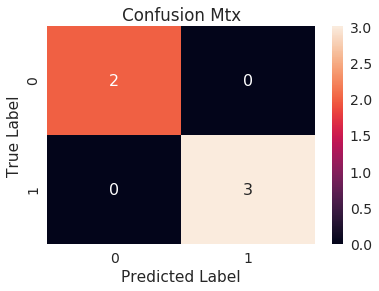

In [53]:
#random forest classifier model
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(numTrees=10)
rf_model = rf.fit(train)
rf_preds = rf_model.transform(validation)
custom_evaluation(rf_preds, 'Random Forest')

Gradient Boosted Trees -> PR AUC: 1.0
Gradient Boosted Trees
 | precision = 1.0
 | recall = 1.0
 | F1-Score = 1.0


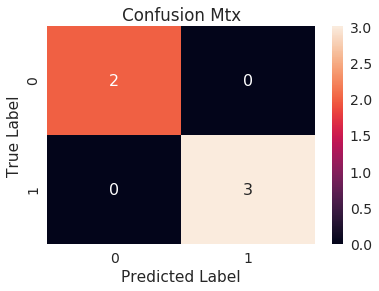

In [54]:
#gradient boosted trees (ie ada boost)
from pyspark.ml.classification import GBTClassifier
gbtrees = GBTClassifier(maxIter=10)
gbtree_model = gbtrees.fit(train)
gbtree_preds = gbtree_model.transform(validation)
custom_evaluation(gbtree_preds, 'Gradient Boosted Trees')

Support Vector Machine -> PR AUC: 1.0
Support Vector Machine
 | precision = 1.0
 | recall = 1.0
 | F1-Score = 1.0


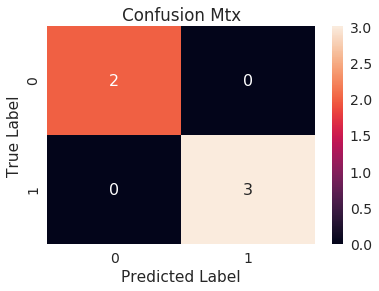

In [56]:
#SVM: https://spark.apache.org/docs/latest/ml-classification-regression.html#linear-support-vector-machine
from pyspark.ml.classification import LinearSVC
svm = LinearSVC(maxIter=10, regParam=0.1)
svm_model=svm.fit(train)
svm_preds=svm_model.transform(validation)
custom_evaluation(svm_preds, 'Support Vector Machine')

Logistic Regression -> PR AUC: 1.0
Logistic Regression
 | precision = 0.4
 | recall = 0.4
 | F1-Score = 0.4


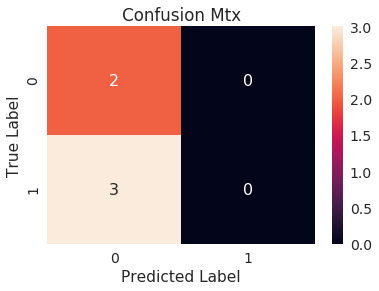

In [57]:
#logistic regression model
from pyspark.ml.classification import LogisticRegression
logReg = LogisticRegression(maxIter=10, regParam=0.3, elasticNetParam=0.8)
lrModel = logReg.fit(train)
lr_preds = lrModel.transform(validation)
custom_evaluation(lr_preds, 'Logistic Regression')

In [ ]:
pipeline=Pipeline(stages=[])
paramGrid=ParamGridBuilder()\
    .addGrid()\
    .build()

cross_val = CrossValidator(estimator=pipeline,
                           estimatorParamMaps=paramGrid,
                           evaluator= ,
                           numFolds=4)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.